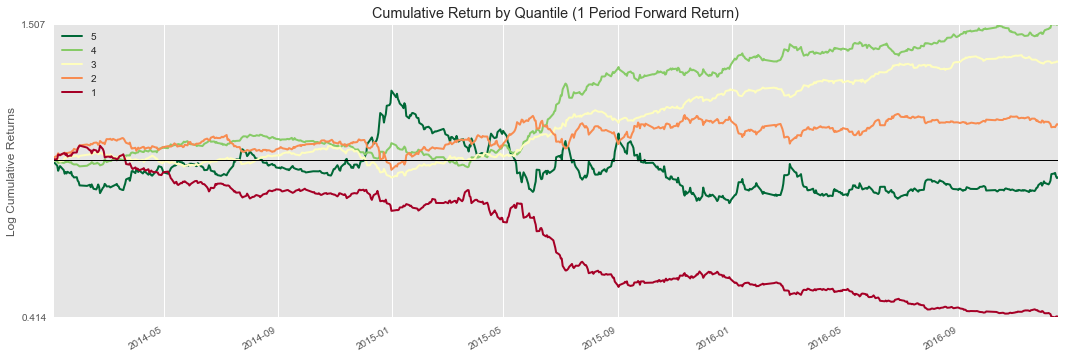

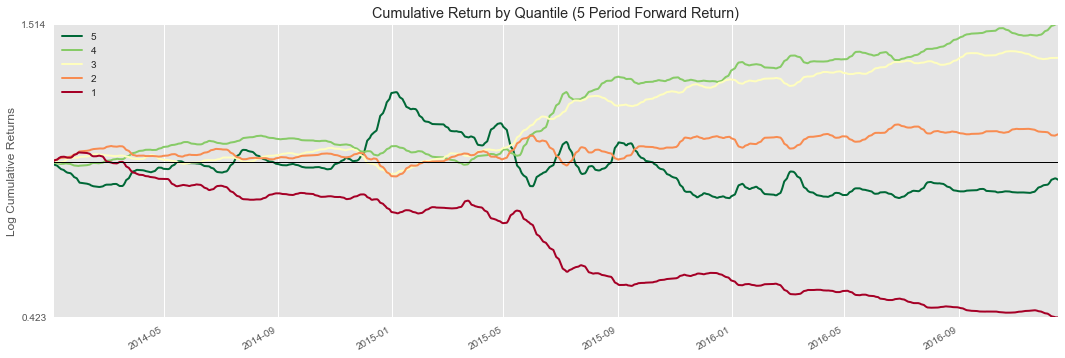

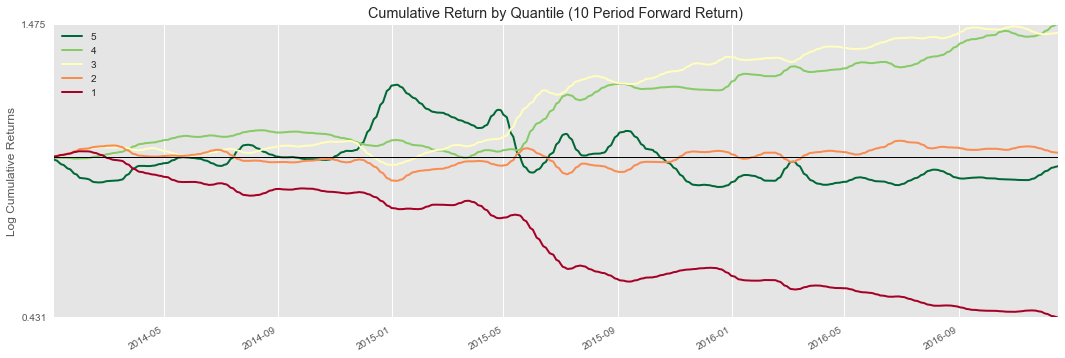

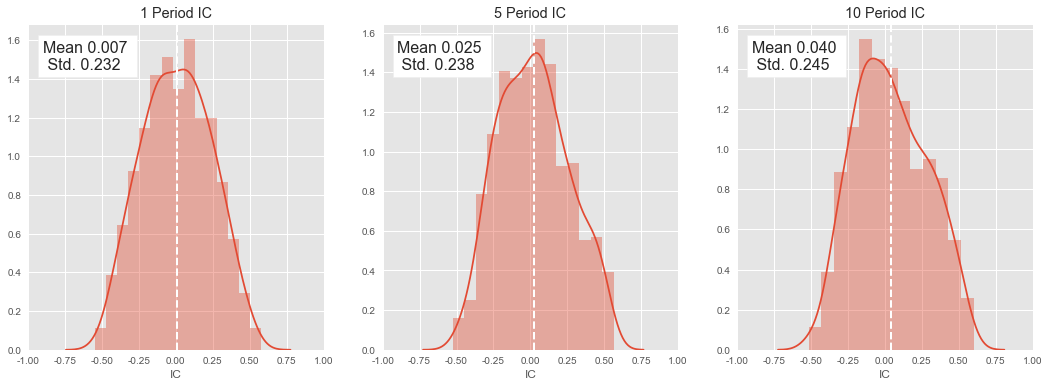

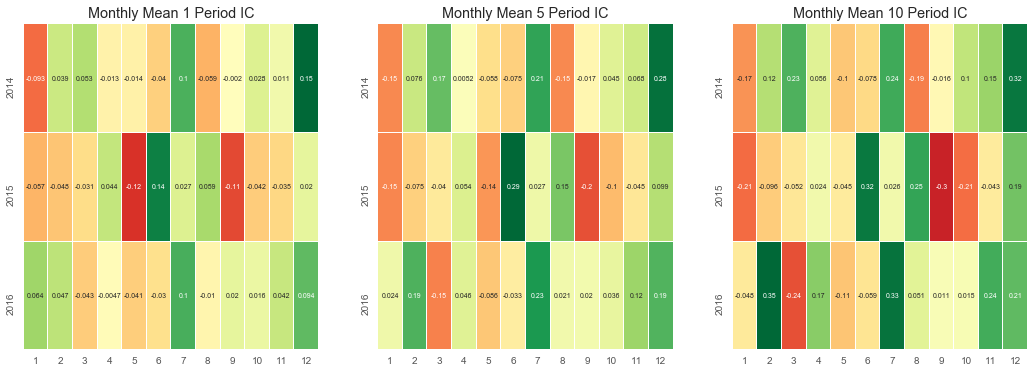

In [48]:
#导入包#
from itertools import chain
from fxdayu_data import DataAPI
from datetime import datetime
import tushare as ts
import numpy as np
# from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
from rqalpha.api import *
from rqalpha import run_func
import os

start = datetime(2014, 1, 1)
end = datetime(2017, 1, 1)

#index = ["SME", "HS300", "GEM", "ZZ500"]
#index = ["SME", "GEM", "ZZ500"]
index = ["HS300", "GEM"]
codes = set(chain(*map(DataAPI.candle.find, index)))
print codes

# close = DataAPI.candle(tuple(codes), "D", start=start, end=end)
factor = DataAPI.factor(tuple(codes), ('ROE', 'PB', 'SFY12P', 'BearPower'), start=datetime(2014, 1, 1), end=datetime(2017, 1, 1))
#从bundle里获取财务指标    
PN = DataAPI.factor(tuple(codes), ('PE', 'PB', 'PS', 'PCF'), start=datetime(2014, 1, 1), end=datetime(2017, 1, 1))
# PN = DataAPI.factor('HS300', ('PE', 'PB', 'PS', 'PCF'), start=datetime(2013, 1, 1))
# close = DataAPI.candle('HS300', 'D', 'close')
close = DataAPI.candle(tuple(codes), "D", start=start, end=end)

prices = close.minor_xs('close')
#测试是否获取数据，打印出来
# print PN
print factor
print prices

#对数据进行极值处理和标准化处理
def winsorize(df):
    q = df.quantile([0.025, 0.975])
    if isinstance(q, pd.Series) and len(q) == 2:
        df[df < q.iloc[0]] = q.iloc[0]
        df[df > q.iloc[1]] = q.iloc[1]
    return df

def standardize(df):
    df_std = df.std()
    df_mean = df.mean()
    return (df - df_mean) / df_std

# S_PE = standardize(winsorize(PN.minor_xs('PE')))
# S_PB = standardize(winsorize(PN.minor_xs('PB')))
# S_PS = standardize(winsorize(PN.minor_xs('PS')))
# S_PCF = standardize(winsorize(PN.minor_xs('PCF')))
# fig = plt.figure(figsize=(15, 7))
# plt.plot(S_PB)
# plt.show()

# #合成因子
# S = -(S_PE+2*S_PB+2*S_PS+0.5*S_PCF)

roe = factor.minor_xs('ROE')
pb = factor.minor_xs('PB')
sfy12p = factor.minor_xs('SFY12P')
bearpower = factor.minor_xs('BearPower')
# nagr = factor.minor_xs('NetAssetGrowRate')

# s = (roe / pb) + nagr * 0.5
s = (roe / pb) * 0.5 + sfy12p
# factor = S.stack()
factor = s.stack()

print(factor)

#求Quantile收益，根据分组测试各组的收益表
import alphalens
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
factor_data
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

#计算IC值
ic = alphalens.performance.factor_information_coefficient(factor_data)
# print ic
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
print mean_monthly_ic
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()


excel_data = factor_data[factor_data.factor_quantile==5].factor_quantile.unstack().replace(np.nan, 0).replace(5, 1)
excel_data.to_excel('factor.xlsx')

In [49]:
bearpower.head()

,000001.XSHE,000002.XSHE,000008.XSHE,000009.XSHE,000027.XSHE,000039.XSHE,000060.XSHE,000061.XSHE,000063.XSHE,000069.XSHE,...,601933.XSHG,601939.XSHG,601958.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601998.XSHG,603000.XSHG,603885.XSHG,603993.XSHG
2014-01-02 15:00:00,-0.0641,-0.1225,-0.0790,0.0554,-0.0378,0.0463,NaN,0.0610,-0.6346,-0.0044,...,-0.0695,-0.0805,-0.1804,NaN,-0.0616,-0.0742,-0.0171,0.6841,NaN,-0.0588
2014-01-03 15:00:00,-0.1954,-0.2360,-0.0753,-0.0950,-0.1293,0.6543,NaN,0.0366,-0.2147,-0.1159,...,0.0503,-0.1110,-0.2166,NaN,-0.0743,-0.1746,-0.0648,0.4945,NaN,-0.0646
2014-01-06 15:00:00,-0.3146,-0.5101,-0.1597,-0.1535,-0.1333,0.2365,NaN,-0.2551,-0.2412,-0.2639,...,-0.0275,-0.1524,-0.4859,NaN,-0.1109,-0.4404,-0.1155,0.0600,NaN,-0.1270
2014-01-07 15:00:00,-0.2750,-0.4708,-0.1606,-0.1095,-0.1434,0.0196,NaN,-0.3047,-0.3968,-0.2404,...,-0.0290,-0.1117,-0.4250,NaN,-0.1065,-0.4017,-0.1209,0.0523,NaN,-0.1141
2014-01-08 15:00:00,-0.2445,-0.3786,-0.1855,-0.1933,-0.1196,0.3518,NaN,-0.1486,-0.3459,-0.2279,...,-0.0017,-0.1194,-0.4505,NaN,-0.0937,-0.3590,-0.0843,0.5470,NaN,-0.1177


In [43]:
excel_data.tail()

asset,000001.XSHE,000002.XSHE,000027.XSHE,000039.XSHE,000060.XSHE,000063.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000333.XSHE,...,601888.XSHG,601899.XSHG,601919.XSHG,601933.XSHG,601939.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601998.XSHG,603885.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2016-12-12 15:00:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2016-12-13 15:00:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2016-12-14 15:00:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2016-12-15 15:00:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2016-12-16 15:00:00,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [44]:
codes = pd.read_excel('factor.xlsx')

# global excel_data
# codes = excel_data
# codes
codes.index = codes.pop('date')

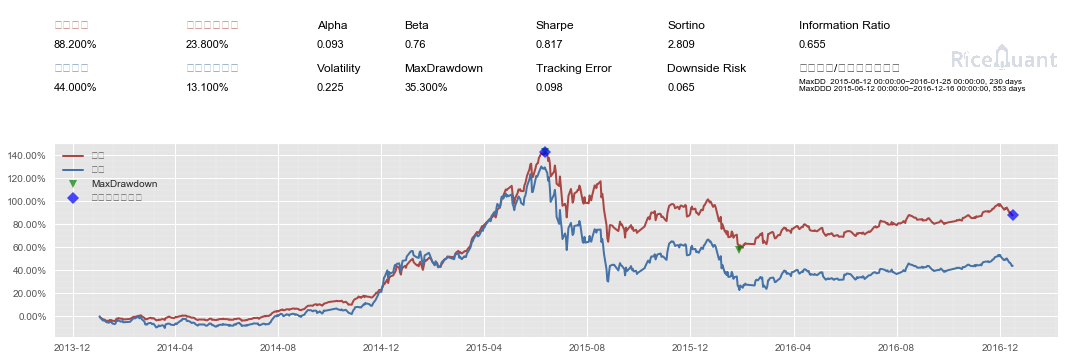

In [45]:
#开始进行回测#


config = {
  "base": {
    "start_date": "2014-01-02",
    "end_date": "2016-12-16",
    "benchmark": "000300.XSHG",
    "accounts": {
        "stock": 100000
    }
  },
  "extra": {
    "log_level": "info",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True,
    },
  }
}

#读取文件位置
def init(context):
#     codes = excel_data
    context.codes = codes
    scheduler.run_monthly(find_pool, tradingday=1)

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now]
    stocks = codes.index[codes == True]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            if codes not in result and codes not in context.portfolio.positions:
                result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

results = run_func(init=init, handle_bar=handle_bar, config=config)

In [ ]:
def init(context):
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 30
    context.stoplossmultipler= 0.98 #止损 乘数 
    context.takepofitmultipler= 3 #止盈 乘数
    
def handle_bar(context, bar_dict):
    entry_exit(context, bar_dict)
    stop_loss(context, bar_dict)
    
def stop_loss(context, bar_dict):
    for stock in context.portfolio.positions:
        if bar_dict[stock].last < context.portfolio.positions[stock].avg_price*context.stoplossmultipler:# 现价低于 原价一定比例
            order_target_percent(stock,0)
        elif bar_dict[stock].last>context.portfolio.positions[stock].avg_price*context.takepofitmultipler:# 现价高于原价一定比例
            order_target_percent(stock,0)
            
def entry_exit(context, bar_dict):
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)
    cur_position = context.portfolio.positions[context.s1].quantity
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        order_target_value(context.s1, 0)
    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        order_target_percent(context.s1, 1)